In [1]:
from i308_calib import *
from i308_utils import *
import cv2
import pickle
import sys
import os
import matplotlib.pyplot as plt
# import stereodemo
import json
import numpy as np

sys.path.append(os.path.abspath(os.path.join("..", "src")))
from calib_funcs import *
from rect_funcs import *
from pnp_funcs import *

%load_ext autoreload
%autoreload 2

In [2]:
with open("../datasets/budha_board/calibration_results/stereo_calibration.pkl", "rb") as f:
    calibration_results = pickle.load(f)

In [3]:
with open("../datasets/budha_board/rectification_results/stereo_rectification.pkl", "rb") as f:
    rectification_results = pickle.load(f)

In [4]:
with open("../datasets/budha_board/depths/depths.pkl", "rb") as f:
    depths = pickle.load(f)

In [5]:
print(calibration_results.keys())
print(rectification_results.keys())
print(depths.keys())

dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])
dict_keys(['R1', 'R2', 'P1', 'P2', 'Q', 'validRoi1', 'validRoi2', 'left_map_x', 'left_map_y', 'right_map_x', 'right_map_y'])
dict_keys(['depths', 'depths_clipped'])


In [6]:
depths_clipped = depths["depths_clipped"]

In [7]:
dir = "../datasets/budha_board/rectified_captures"
left_imgs, right_imgs = get_images(dir, prefix="", ext="jpg", print_info=True)

Found 6 left images and 6 right images
First left image: ..\datasets\budha_board\rectified_captures\left_rectified_0.jpg
First right image: ..\datasets\budha_board\rectified_captures\right_rectified_0.jpg


In [12]:
def export_ply(archivo_ply, depth_map, img_color, f, cx, cy):
    """
    Exporta el mapa de profundidad y la imagen de color a un archivo .PLY.

    Parámetros:
        archivo_ply (str): Ruta del archivo de salida .PLY.
        depth_map (numpy.ndarray): Mapa de profundidad.
        img_color (numpy.ndarray): Imagen original en color.
        f (float): Distancia focal de la cámara (en píxeles).
        cx, cy (float): Coordenadas del centro óptico (en píxeles).
    """
    h, w = depth_map.shape
    with open(archivo_ply, 'w') as f_out:
        # Cabecera del archivo .PLY
        f_out.write('ply\n')
        f_out.write('format ascii 1.0\n')
        f_out.write(f'element vertex {h * w}\n')
        f_out.write('property float x\n')
        f_out.write('property float y\n')
        f_out.write('property float z\n')
        f_out.write('property uchar red\n')
        f_out.write('property uchar green\n')
        f_out.write('property uchar blue\n')
        f_out.write('end_header\n')

        for y in range(h):
            for x in range(w):
                Z = depth_map[y, x]
                if Z == 0:  # skippea píxeles con profundidad 0
                    continue
                
                # convierte coordenadas de píxel a coordenadas de mundo 3D
                X = (x - cx) * Z / f
                Y = (y - cy) * Z / f

                # color de la imagen original (en BGR)
                color = img_color[y, x]
                r, g, b = color[2], color[1], color[0]

                # escribie el punto 3D y su color al archivo PLY
                f_out.write(f'{X} {Y} {Z} {r} {g} {b}\n')

    print(f'Archivo .PLY guardado como {archivo_ply}')

In [13]:
index=0
left_K = calibration_results["left_K"]
export_ply(
    f"buda{index}.ply",
    depths_clipped[index],
    left_imgs[index],
    left_K[0, 0],
    left_K[0, 2],
    left_K[1, 2],

)

Archivo .PLY guardado como buda0.ply


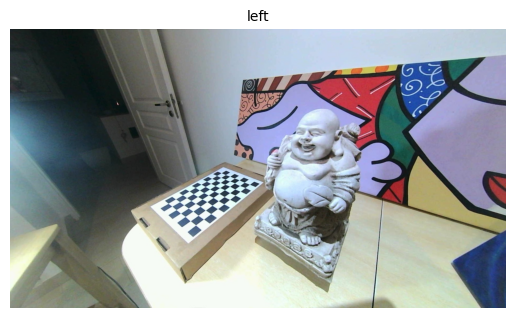

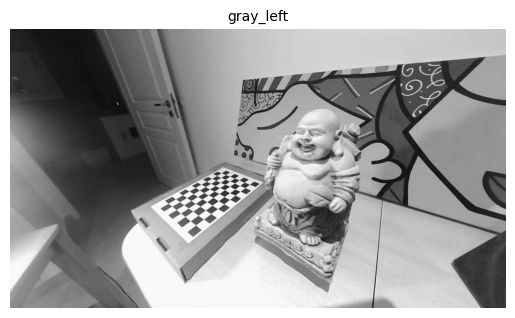

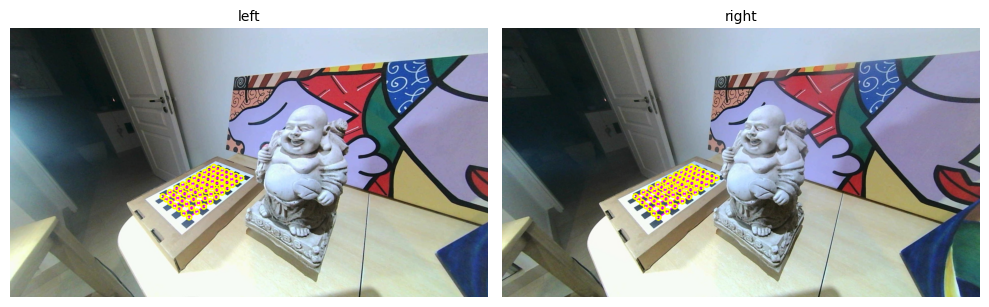

In [ ]:
idx = 3
left_img = left_imgs[idx]
right_img = right_imgs[idx]
imshow(left_img, "left")
# fiajarse que las guarde bien en gris en disparity!
gray_left = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY) 
gray_right = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
imshow(gray_left, "gray_left")
checkerboard, square_size_mm = load_checkerboard_config("../datasets/budha_board/checkerboard.txt")
print(checkerboard)
left_found, left_corners = detect_board(checkerboard, gray_left)
right_found, right_corners = detect_board(checkerboard, gray_right)
show_left = left_img.copy()
show_right = right_img.copy()
draw_settings = {
    "corner_radius": 10,
    "corner_thickness": 5,
    "line_thickness": 4
}
draw_checkerboard(show_left, checkerboard, left_corners, True, **draw_settings)
draw_checkerboard(show_right, checkerboard, right_corners, True, **draw_settings)

show_images([show_left, show_right], ["left", "right"])



object_3dpoints = board_points(checkerboard)

object_3dpoints_mm = object_3dpoints * square_size_mm


ret, rvec, tvec = cv2.solvePnP(object_3dpoints_mm,
                               left_corners,
                               calibration_results["left_K"],
                                 calibration_results["left_dist"],
                                 flags=cv2.SOLVEPNP_IPPE)
c_R_o = cv2.Rodrigues(rvec)
c_T_o = np.column_stack((c_R_o[0], tvec))
c_T_o = np.vstack((c_T_o, [0, 0, 0, 1]))
o_T_c = np.linalg.inv(c_T_o)


In [14]:
print(o_T_c.shape)
print(o_T_c)

(4, 4)
[[-3.17508362e-01  4.29870028e-01 -8.45221982e-01  4.26123321e+02]
 [-9.47242870e-01 -1.84962892e-01  2.61762630e-01 -2.32553794e+02]
 [-4.38107935e-02  8.83742320e-01  4.65918584e-01 -3.40617207e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [15]:
checkerboard_path = "../datasets/budha_board/checkerboard.txt"
o_T_c_list = get_matrixs(left_imgs, calibration_results, checkerboard_path)

In [16]:
poses = {i: o_T_c_list[i] for i in range(len(o_T_c_list))}
path = "../datasets/budha_board/poses/poses.pkl"
write_pickle(path, poses)


'..\\datasets\\budha_board\\poses\\poses.pkl'